# Prediction

Having collected, cleaned and organized the data with information about ratings, cast, genre and past Oscar performances, we will now try to predict the winners and nominees. The approach that we take is the following. 

Because we have seen that a movie almost has to be in one of the three major categories -- drama, romance, comedy or biograpjy -- we will filter our data to only consider the movie that fall into oine of thes egenres. 
We will then use a variety of different models to predict the probabibility of win for the different movies. The movies will be sorted in descending order of win probabilities. 

Finally, we will take a aweighted average of al the prediction, weighted by the recall score, and use the grand average as our final prediction. 

In [1]:
# import necessary libraries
import pandas as pd
import collections
import numpy as np
import requests
import wikipedia
import re
import matplotlib.pyplot as plt
import seaborn as sns
from bs4 import BeautifulSoup
from urllib.request import urlopen
from scrapy import selector
import datetime as dt
import pickle
from skimage import io
from IPython.display import clear_output
%matplotlib inline

# scikit learn
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report 
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV 
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeRegressor  
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix

In [2]:
DF_main = pd.read_csv('my_data/DF_MAIN.csv', index_col=[0])

ID_columns = ['imdbID', 'title', 'year']
basic_columns = ['cast_size', 'genre_span']
all_genres = pickle.load(open("my_data/all_genres_omdb","rb"))
all_genres.remove('adult')
all_genres.remove('n/a')

scores = ['n_votes','imdb_rating', 'metscore', 'rotten_tomatoes']
awards_pre = ['precount_wins', 'precount_noms', 'other_wins', 'other_noms']
awards_post = ['win', 'nom']

predictor_columns = basic_columns + all_genres + scores + awards_pre
target_columns = awards_post

filters = (DF_main.drama==1)|((DF_main.comedy==1)|(DF_main.romance==1)|(DF_main.biography==1))
DF_main = DF_main[filters]

In [3]:
print('The following 2019 movies are being considered:\n')
print(list(DF_main.query("year == 2019").title))

The following 2019 movies are being considered:

['avengers: endgame', 'toy story 4', 'frozen ii', 'it chapter two', "a dog's way home", 'glass', 'close', 'the lego movie 2: the second part', 'what men want', 'cold pursuit', 'high flying bird', "isn't it romantic", 'happy death day 2u', 'fighting with my family', 'triple frontier', 'wonder park', 'captive state', 'nancy drew and the hidden staircase', 'the aftermath', 'five feet apart', 'the highwaymen', 'the dirt', 'unplanned', 'shazam!', 'the best of enemies', 'the haunting of sharon tate', 'the silence', 'missing link', 'after', 'breakthrough', 'i trapped the devil', 'long shot', 'the intruder', 'uglydolls', 'extremely wicked, shockingly evil and vile', 'pokémon detective pikachu', 'the hustle', 'tolkien', 'poms', 'the professor and the madman', "a dog's journey", 'the sun is also a star', 'the souvenir', 'the tomorrow man', 'brightburn', 'always be my maybe', 'rocketman', 'the secret life of pets 2', 'late night', 'men in black: in

In [4]:
def convert_to_pctile(X, columns):
    
    for col in columns:
        x = np.array(X[col])
        X[col] = [(len(np.where(x<=y)[0])/len(x)) for y in x]
    return X

def normalize_by_max(X, columns):
    for col in columns:
        x = np.array(X[col])
        mx = np.max(x)
        X[col] = x/mx
    return X

def top_N_each_year(df,N,feature):
    df_ = pd.DataFrame()
    for year in list(set(df.year)):
        # print(year)
        df_ = df_.append(df[df.year == year].sort_values(by = feature, ascending=False).head(N))
    return df_

def normalize_by_year(df, columns, _how = 'max'):
    
    if type(columns)!= list:
        print("columns must be list")
        return dict()
    years = list(set(df.year))

    print(years)
    
    if _how == 'pctile':
        df = convert_to_pctile(df, columns)
        return df

    for column in columns:
        cols = ['year'] + [column]
        for year in years:
            if year%10 == 0:
                clear_output() 
            print(year, column)
            temp_df = df[(df.year == year)]
            temp_df = temp_df[column]
            ids = temp_df.index
            
            if _how == 'max':
                df.loc[ids,column] = df.loc[ids,column]/temp_df.max()
            if _how == 'minmax':
                min_max_scaler = preprocessing.MinMaxScaler()
                vals = df.loc[ids,column].values
                # vals.shape = (len(vals),1)
                print(vals.shape)
                vals = vals[:,np.newaxis]
                print(vals.shape)
                scaled_array = min_max_scaler.fit_transform(vals)
                df.loc[ids,column] = scaled_array
            
                
    return df

In [5]:
print(DF_main.columns)
normalize_columns = ['n_votes', 'imdb_rating', 'metscore', 'rotten_tomatoes',
                     'cast_size', 'genre_span', 'cast_size', 'running_time']
# DF = normalize_by_year(DF_main, normalize_columns, 'max')
DF = normalize_by_year(DF_main, normalize_columns, 'max')

2010 running_time
2011 running_time
2012 running_time
2013 running_time
2014 running_time
2015 running_time
2016 running_time
2017 running_time
2018 running_time
2019 running_time


In [6]:
DF.columns

Index(['imdbID', 'title', 'year', 'n_votes', 'imdb_rating', 'budget',
       'box_office', 'cast_size', 'genre_span', 'running_time', 'metscore',
       'rotten_tomatoes', 'other_wins', 'other_noms', 'precount_wins',
       'precount_noms', 'win', 'nom', 'mystery', 'sci-fi', 'biography',
       'comedy', 'news', 'talk-show', 'horror', 'documentary', 'thriller',
       'short', 'crime', 'sport', 'war', 'animation', 'fantasy', 'musical',
       'action', 'drama', 'history', 'western', 'game-show', 'romance',
       'reality-tv', 'family', 'music', 'adventure', 'film-noir'],
      dtype='object')

In [7]:
DFX = DF[(DF.year >=1960)&(DF.year < 2019)][ID_columns + predictor_columns + target_columns]
print("predictor columns:",predictor_columns)
print("target columns:",target_columns)


y = (DFX.win > 1)|(DFX.nom>3) # 2 wins of 4 nominations
y = np.array([int(z) for z in y])
DFX['target'] = y
y = y[:,np.newaxis]
print("y shape:", y.shape)
X = DFX[predictor_columns]

DFX_2019 = DF[DF.year == 2019][ID_columns + predictor_columns + target_columns]
X_2019 = DFX_2019[predictor_columns]
print("X_2019 shape:",X_2019.shape)


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0, stratify = y)
print("Class 0:", len(y_train[np.where(y_train == 0)]))
print("Class 1:", len(y_train[np.where(y_train == 1)]))
print("2019:", )





predictor columns: ['cast_size', 'genre_span', 'mystery', 'sci-fi', 'biography', 'comedy', 'news', 'talk-show', 'horror', 'documentary', 'thriller', 'short', 'crime', 'sport', 'war', 'animation', 'fantasy', 'musical', 'action', 'drama', 'history', 'western', 'game-show', 'romance', 'reality-tv', 'family', 'music', 'adventure', 'n_votes', 'imdb_rating', 'metscore', 'rotten_tomatoes', 'precount_wins', 'precount_noms', 'other_wins', 'other_noms']
target columns: ['win', 'nom']
y shape: (3532, 1)
X_2019 shape: (140, 36)
Class 0: 2342
Class 1: 130
2019:


In [8]:
X[y==1].head()

,cast_size,genre_span,mystery,sci-fi,biography,comedy,news,talk-show,horror,documentary,...,music,adventure,n_votes,imdb_rating,metscore,rotten_tomatoes,precount_wins,precount_noms,other_wins,other_noms
7,0.909091,0.666667,0,0,0,0,0,0,0,0,...,0,0,1.000000,0.906977,0.833333,0.898990,1,2,115.0,80.0
119,0.208333,0.600000,0,0,0,0,0,0,0,0,...,0,0,0.977537,0.988764,0.836735,0.734694,3,2,42.0,73.0
120,0.307692,0.800000,1,0,0,0,0,0,0,0,...,0,0,0.819565,0.941860,0.711111,0.860000,0,0,32.0,48.0
175,0.250000,0.800000,0,0,1,0,0,0,0,0,...,0,1,0.917785,0.975610,0.800000,0.790000,3,4,88.0,185.0
187,0.363636,0.800000,0,0,0,0,0,0,0,0,...,0,0,0.196281,0.804598,0.559140,0.770833,0,0,16.0,23.0


In [9]:
name = []
accuracy = []
recall = []
precision = []

# Logistic Regression

Because we are interested in obtaining probabilities for each film earning a nomination, and inferring the winner from these probabilities, the only linear model that was considered was Logistic Regression. Because Logistic regression uses the logistic function to model a binary dependent variable, the output of the model can be naturally interpreted as the probability of nomination or not. 

{'C': 2.7825594022071245, 'penalty': 'l1'}
0.9595130237825594
              precision    recall  f1-score   support

     class 0       0.96      0.99      0.97      1004
     class 1       0.58      0.25      0.35        56

    accuracy                           0.95      1060
   macro avg       0.77      0.62      0.66      1060
weighted avg       0.94      0.95      0.94      1060

Confusion Matrix:
 [[994  10]
 [ 42  14]]


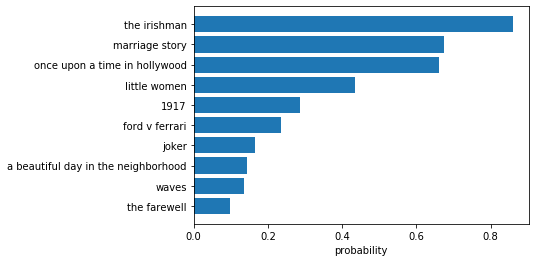

In [10]:
log = LogisticRegression(random_state=0)
penalty = ['l1', 'l2']
C = np.logspace(0, 4, 10)
hyperparameters = dict(C=C, penalty=penalty)
log_cv = GridSearchCV(log, hyperparameters, cv=5, verbose=0)
log_cv.fit(X, y)
y_pred = log_cv.predict(X_2019)
y_prob = log_cv.predict_proba(X_2019)[:,1]
DFX_2019.loc[:,'predicted_probability_log'] = y_prob
x = DFX_2019.sort_values(by='predicted_probability_log', ascending=False).head(10)
clear_output()

### Performance evaluation
log_cv.fit(X_train, y_train)
y_pred = log_cv.predict(X_test)
target_names = ['class 0', 'class 1']
clear_output() 
x = x.iloc[::-1,:]
print(log_cv.best_params_)
print(log_cv.score(X, y))
plt.barh(x['title'], x['predicted_probability_log'])
plt.xlabel('probability')
print(classification_report(y_test, y_pred, target_names=target_names))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

In [11]:
name.append('log')
accuracy.append(0.96)
recall.append(0.25)
precision.append(0.58)
print(name, accuracy, recall, precision)

['log'] [0.96] [0.25] [0.58]


## K Nearest neighbors classifier 
K nearest neighbor is a nonlinear classifier that provided straightforward approach to classify movies based on their proximity to previous winners and nominees. We used GridSearchCV() method from the utils package of scikit-learn module. Although several variations were available, we only performed grid search on the number parameters, whose optimal value was found to be 15. 

{'n_neighbors': 5}
0.9583805209513023
              precision    recall  f1-score   support

     class 0       0.96      0.98      0.97      1004
     class 1       0.42      0.23      0.30        56

    accuracy                           0.94      1060
   macro avg       0.69      0.61      0.63      1060
weighted avg       0.93      0.94      0.93      1060

Confusion Matrix:
 [[986  18]
 [ 43  13]]


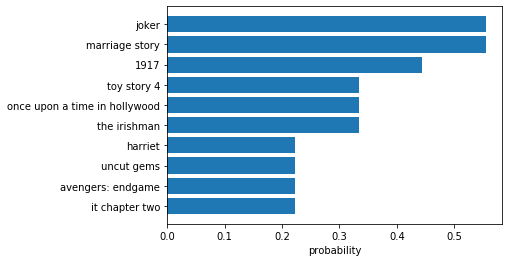

In [12]:
# KNN Training
knn = KNeighborsClassifier(n_neighbors=5)
param_grid = {'n_neighbors': np.arange(1, 30)} 
knn_cv = GridSearchCV(knn, param_grid, cv=5) 
# knn.fit(X, y) 
knn_cv.fit(X, y)

# KNN prediction
y_pred = knn_cv.predict(X_2019)
y_prob = knn_cv.predict_proba(X_2019)
DFX_2019.loc[:,'predicted_probability_knn'] = y_prob[:,1]
x = DFX_2019.sort_values(by='predicted_probability_knn', ascending=False).head(10)
clear_output()


### Performance evaluation
knn_cv.fit(X_train, y_train)
y_pred = knn_cv.predict(X_test)
target_names = ['class 0', 'class 1']
clear_output() 
x = x.iloc[::-1,:]
print(knn_cv.best_params_)
print(knn_cv.score(X, y))
plt.barh(x['title'], x['predicted_probability_knn'])
plt.xlabel('probability')
print(classification_report(y_test, y_pred, target_names=target_names))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


In [13]:
name.append('knn')
accuracy.append(0.96)
recall.append(0.23)
precision.append(0.42)
print(name, accuracy, recall, precision)

['log', 'knn'] [0.96, 0.96] [0.25, 0.23] [0.58, 0.42]


# Random Forest Classifier

{'n_estimators': 80}
0.9858437146092865
              precision    recall  f1-score   support

     class 0       0.96      0.99      0.98      1004
     class 1       0.65      0.23      0.34        56

    accuracy                           0.95      1060
   macro avg       0.80      0.61      0.66      1060
weighted avg       0.94      0.95      0.94      1060

Confusion Matrix:
 [[997   7]
 [ 43  13]]


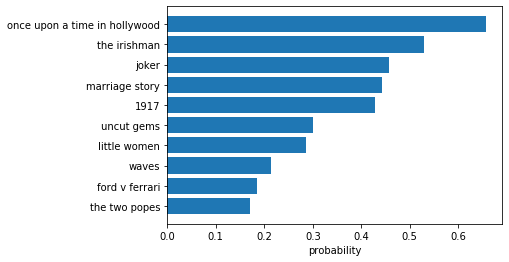

In [14]:
rfc=RandomForestClassifier() # n_estimators=100)
param_grid = {'n_estimators': np.arange(50,100,5)} 
rfc_cv = GridSearchCV(rfc, param_grid, cv=5) 

rfc_cv.fit(X,y)
y_pred = rfc_cv.predict(X_2019)
y_prob = rfc_cv.predict_proba(X_2019)
DFX_2019.loc[:,'predicted_probability_rfc'] = y_prob[:,1]
x = DFX_2019.sort_values(by='predicted_probability_rfc', ascending=False).head(10)

### Performance evaluation
rfc_cv.fit(X_train, y_train)
y_pred = rfc_cv.predict(X_test)
target_names = ['class 0', 'class 1']
clear_output() 
x = x.iloc[::-1,:]
print(rfc_cv.best_params_)
print(rfc_cv.score(X, y))
plt.barh(x['title'], x['predicted_probability_rfc'])
plt.xlabel('probability')
print(classification_report(y_test, y_pred, target_names=target_names))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


In [15]:
name.append('rfc')
accuracy.append(0.98)
recall.append(0.23)
precision.append(0.50)
print(name, accuracy, recall, precision)

['log', 'knn', 'rfc'] [0.96, 0.96, 0.98] [0.25, 0.23, 0.23] [0.58, 0.42, 0.5]


# Ensemble Methods: Bag of KNN

0.953850509626274
              precision    recall  f1-score   support

     class 0       0.96      0.99      0.97      1004
     class 1       0.46      0.21      0.29        56

    accuracy                           0.95      1060
   macro avg       0.71      0.60      0.63      1060
weighted avg       0.93      0.95      0.94      1060

Confusion Matrix:
 [[990  14]
 [ 44  12]]


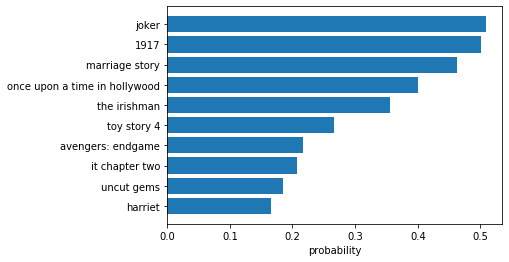

In [16]:
bag = BaggingClassifier(base_estimator=KNeighborsClassifier(n_neighbors=10), n_estimators=100, random_state=42)
bag.fit(X, y)
y_pred = bag.predict(X_2019)
y_prob = bag.predict_proba(X_2019)
DFX_2019.loc[:,'predicted_probability_bag'] = y_prob[:,1]
clear_output()
x = DFX_2019.sort_values(by='predicted_probability_bag', ascending=False).head(10)


### Performance evaluation
bag.fit(X_train, y_train)
y_pred = bag.predict(X_test)
target_names = ['class 0', 'class 1']
clear_output() 
x = x.iloc[::-1,:]
# print(bag.best_params_)
print(bag.score(X, y))
plt.barh(x['title'], x['predicted_probability_bag'])
plt.xlabel('probability')
print(classification_report(y_test, y_pred, target_names=target_names))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

In [17]:
name.append('bag')
accuracy.append(0.95)
recall.append(0.21)
precision.append(0.46)
print(name, accuracy, recall, precision)

['log', 'knn', 'rfc', 'bag'] [0.96, 0.96, 0.98, 0.95] [0.25, 0.23, 0.23, 0.21] [0.58, 0.42, 0.5, 0.46]


# Adaptive Boosting (Adaboost)

0.970554926387316
              precision    recall  f1-score   support

     class 0       0.96      0.98      0.97      1004
     class 1       0.54      0.34      0.42        56

    accuracy                           0.95      1060
   macro avg       0.75      0.66      0.70      1060
weighted avg       0.94      0.95      0.94      1060

Confusion Matrix:
 [[988  16]
 [ 37  19]]


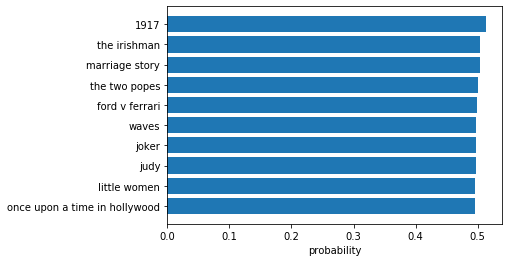

In [18]:
ada = AdaBoostClassifier(n_estimators=100, random_state=47)
ada.fit(X, y)
y_pred = ada.predict(X_2019)
y_prob = ada.predict_proba(X_2019)

DFX_2019.loc[:,'predicted_probability_ada'] = y_prob[:,1]
clear_output()
print(ada.score(X,y))
x = DFX_2019.sort_values(by='predicted_probability_ada', ascending=False).head(10)
# print(bag.best_params_)
x = x.iloc[::-1,:]


### Performance evaluation
ada.fit(X_train, y_train)
y_pred = ada.predict(X_test)
target_names = ['class 0', 'class 1']
clear_output() 
# print(ada.best_params_)
print(ada.score(X, y))
plt.barh(x['title'], x['predicted_probability_ada'])
plt.xlabel('probability')
print(classification_report(y_test, y_pred, target_names=target_names))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

In [19]:
name.append('ada')
accuracy.append(0.97)
recall.append(0.34)
precision.append(0.54)
print(name, accuracy, recall, precision)

['log', 'knn', 'rfc', 'bag', 'ada'] [0.96, 0.96, 0.98, 0.95, 0.97] [0.25, 0.23, 0.23, 0.21, 0.34] [0.58, 0.42, 0.5, 0.46, 0.54]


# Neural Network

0.95158550396376
              precision    recall  f1-score   support

     class 0       0.95      0.99      0.97      1004
     class 1       0.50      0.14      0.22        56

    accuracy                           0.95      1060
   macro avg       0.73      0.57      0.60      1060
weighted avg       0.93      0.95      0.93      1060

Confusion Matrix:
 [[996   8]
 [ 48   8]]


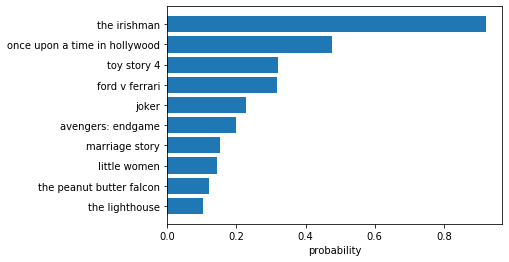

In [20]:
mlp = MLPClassifier(solver='sgd', alpha=1e-5, hidden_layer_sizes=(10,10), max_iter=1000, random_state=41)
mlp.fit(X, y)
y_pred = mlp.predict(X_2019)
y_prob = mlp.predict_proba(X_2019)
# print(y_prob)
# print(classifier.score)
DFX_2019.loc[:,'predicted_probability_mlp'] = y_prob[:,1]
clear_output()
print(mlp.score(X, y))
x = DFX_2019.sort_values(by='predicted_probability_mlp', ascending=False).head(10)
x = x.iloc[::-1,:]


### Performance evaluation
mlp.fit(X_train, y_train)
y_pred = mlp.predict(X_test)
target_names = ['class 0', 'class 1']
clear_output() 
print(mlp.score(X, y))
plt.barh(x['title'], x['predicted_probability_mlp'])
plt.xlabel('probability')
print(classification_report(y_test, y_pred, target_names=target_names))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

In [21]:
name.append('mlp')
accuracy.append(0.95)
recall.append(0.14)
precision.append(0.50)
print(name, accuracy, recall, precision)

['log', 'knn', 'rfc', 'bag', 'ada', 'mlp'] [0.96, 0.96, 0.98, 0.95, 0.97, 0.95] [0.25, 0.23, 0.23, 0.21, 0.34, 0.14] [0.58, 0.42, 0.5, 0.46, 0.54, 0.5]


# Ensemble of Neural Networks

0.9552661381653454
              precision    recall  f1-score   support

     class 0       0.96      0.99      0.97      1004
     class 1       0.52      0.20      0.29        56

    accuracy                           0.95      1060
   macro avg       0.74      0.59      0.63      1060
weighted avg       0.93      0.95      0.94      1060

Confusion Matrix:
 [[994  10]
 [ 45  11]]


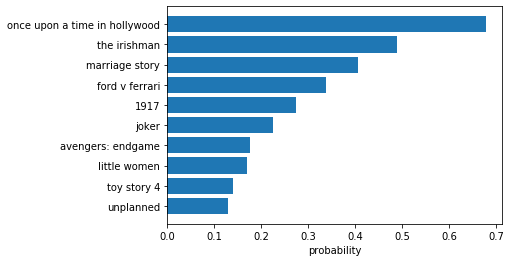

In [22]:
mlp = MLPClassifier(solver='sgd')
mlp_bag = BaggingClassifier(base_estimator=mlp, n_estimators=100, random_state=42).fit(X, y)
y_pred = mlp_bag.predict(X_2019)
y_prob = mlp_bag.predict_proba(X_2019)
DFX_2019.loc[:,'predicted_probability_mlpbag'] = y_prob[:,1]
x = DFX_2019.sort_values(by='predicted_probability_mlpbag', ascending=False).head(10)
x = x.iloc[::-1,:]


### Performance evaluation
mlp_bag.fit(X_train, y_train)
y_pred = mlp_bag.predict(X_test)
target_names = ['class 0', 'class 1']
clear_output() 
print(mlp_bag.score(X, y))
plt.barh(x['title'], x['predicted_probability_mlpbag'])
plt.xlabel('probability')
print(classification_report(y_test, y_pred, target_names=target_names))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

In [23]:
name.append('mlpbag')
accuracy.append(0.96)
recall.append(0.20)
precision.append(0.52)
print(name, accuracy, recall, precision)

['log', 'knn', 'rfc', 'bag', 'ada', 'mlp', 'mlpbag'] [0.96, 0.96, 0.98, 0.95, 0.97, 0.95, 0.96] [0.25, 0.23, 0.23, 0.21, 0.34, 0.14, 0.2] [0.58, 0.42, 0.5, 0.46, 0.54, 0.5, 0.52]


In [28]:
performance_df = pd.DataFrame({'classifier': name, 'accuracy':accuracy, 'recall':recall, 'precision':precision})
performance_df.set_index('classifier', inplace=True)
performance_df
pickle.dump(performance_df,open('my_data/performance_df', "wb" ))


# Grand Average Prediction

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], <a list of 10 Text xticklabel objects>)

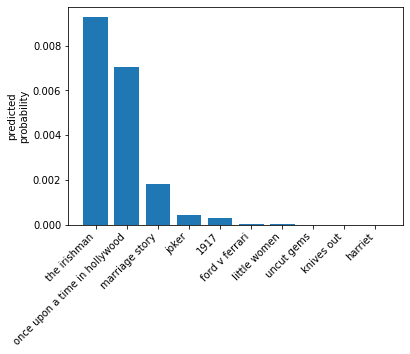

In [25]:


field = 'accuracy'
DFX_2019['final_proba'] = 1
DFX_2019['final_proba'] = DFX_2019['final_proba'] * DFX_2019['predicted_probability_log']*performance_df.loc['log',field] 
DFX_2019['final_proba'] = DFX_2019['final_proba'] * DFX_2019['predicted_probability_knn']*performance_df.loc['knn',field] 
DFX_2019['final_proba'] = DFX_2019['final_proba'] * DFX_2019['predicted_probability_rfc']*performance_df.loc['rfc',field] 
DFX_2019['final_proba'] = DFX_2019['final_proba'] * DFX_2019['predicted_probability_bag']*performance_df.loc['bag',field] 
DFX_2019['final_proba'] = DFX_2019['final_proba'] * DFX_2019['predicted_probability_ada']*performance_df.loc['ada',field] 
DFX_2019['final_proba'] = DFX_2019['final_proba'] * DFX_2019['predicted_probability_mlp']*performance_df.loc['mlp',field] 
DFX_2019['final_proba'] = DFX_2019['final_proba'] * DFX_2019['predicted_probability_mlpbag']*performance_df.loc['mlpbag',field] 





DFX_2019.columns
x = DFX_2019.sort_values(by='final_proba', ascending=False).head(10)
# print(bag.best_params_)
# x = x.iloc[::-1,:]
plt.bar(x['title'], x['final_proba'])
plt.xticks(rotation=90)
plt.ylabel('predicted\nprobability')
plt.xticks(rotation=45, horizontalalignment = 'right')



([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], <a list of 10 Text xticklabel objects>)

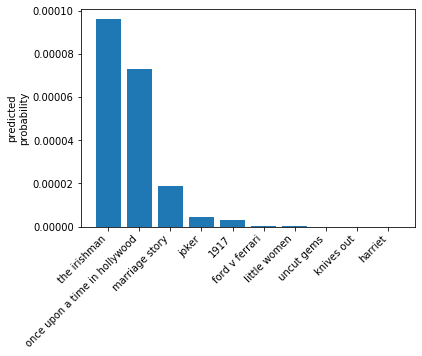

In [26]:


field = 'precision'
DFX_2019['final_proba'] = 1
DFX_2019['final_proba'] = DFX_2019['final_proba'] * DFX_2019['predicted_probability_log']*performance_df.loc['log',field] 
DFX_2019['final_proba'] = DFX_2019['final_proba'] * DFX_2019['predicted_probability_knn']*performance_df.loc['knn',field] 
DFX_2019['final_proba'] = DFX_2019['final_proba'] * DFX_2019['predicted_probability_rfc']*performance_df.loc['rfc',field] 
DFX_2019['final_proba'] = DFX_2019['final_proba'] * DFX_2019['predicted_probability_bag']*performance_df.loc['bag',field] 
DFX_2019['final_proba'] = DFX_2019['final_proba'] * DFX_2019['predicted_probability_ada']*performance_df.loc['ada',field] 
DFX_2019['final_proba'] = DFX_2019['final_proba'] * DFX_2019['predicted_probability_mlp']*performance_df.loc['mlp',field] 
DFX_2019['final_proba'] = DFX_2019['final_proba'] * DFX_2019['predicted_probability_mlpbag']*performance_df.loc['mlpbag',field] 





DFX_2019.columns
x = DFX_2019.sort_values(by='final_proba', ascending=False).head(10)
# print(bag.best_params_)
# x = x.iloc[::-1,:]
plt.bar(x['title'], x['final_proba'])
plt.xticks(rotation=90)
plt.ylabel('predicted\nprobability')
plt.xticks(rotation=45, horizontalalignment = 'right')



([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], <a list of 10 Text xticklabel objects>)

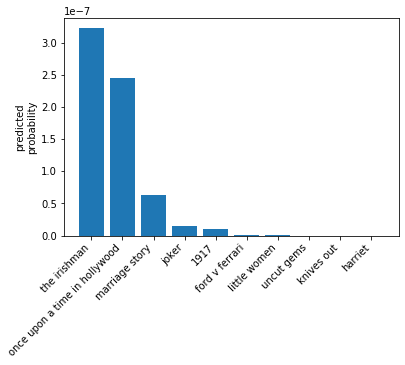

In [27]:
# DFX_2019['final_proba'] = DFX_2019[[
#     'predicted_probability_log', 'predicted_probability_rfc',
#        'predicted_probability_knn', 'predicted_probability_bag',
#        'predicted_probability_ada', 'predicted_probability_mlp',
#        'predicted_probability_mlpbag']].prod(axis=1)

field = 'recall'
DFX_2019['final_proba'] = 1
DFX_2019['final_proba'] = DFX_2019['final_proba'] * DFX_2019['predicted_probability_log']*performance_df.loc['log',field] 
DFX_2019['final_proba'] = DFX_2019['final_proba'] * DFX_2019['predicted_probability_knn']*performance_df.loc['knn',field] 
DFX_2019['final_proba'] = DFX_2019['final_proba'] * DFX_2019['predicted_probability_rfc']*performance_df.loc['rfc',field] 
DFX_2019['final_proba'] = DFX_2019['final_proba'] * DFX_2019['predicted_probability_bag']*performance_df.loc['bag',field] 
DFX_2019['final_proba'] = DFX_2019['final_proba'] * DFX_2019['predicted_probability_ada']*performance_df.loc['ada',field] 
DFX_2019['final_proba'] = DFX_2019['final_proba'] * DFX_2019['predicted_probability_mlp']*performance_df.loc['mlp',field] 
DFX_2019['final_proba'] = DFX_2019['final_proba'] * DFX_2019['predicted_probability_mlpbag']*performance_df.loc['mlpbag',field] 





DFX_2019.columns
x = DFX_2019.sort_values(by='final_proba', ascending=False).head(10)
# print(bag.best_params_)
# x = x.iloc[::-1,:]
plt.bar(x['title'], x['final_proba'])
plt.xticks(rotation=90)
plt.ylabel('predicted\nprobability')
plt.xticks(rotation=45, horizontalalignment = 'right')

